# Task 4: Bucket FICO scores

In this last task, given a task that needs a general approach to generating the buckets. Given a set number of buckets corresponding to the number of input labels for the model to find out the boundaries that best summarize the data. I need to create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.

## Load the Data

First, load the dataset that will be needed.

In [1]:
import pandas as pd

In [4]:
file_path = 'Task 3 and 4_Loan_Data.csv'
data = pd.read_csv(file_path)

In [7]:
data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


## Preprocessing Data

In this stage, describe first to find out statistics on the data. 

In [8]:
data.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


Then also find out what the data info is like. 

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


## Plot the Data

Plot the data to see what the data distribution is like.

In [10]:
import matplotlib.pyplot as plt

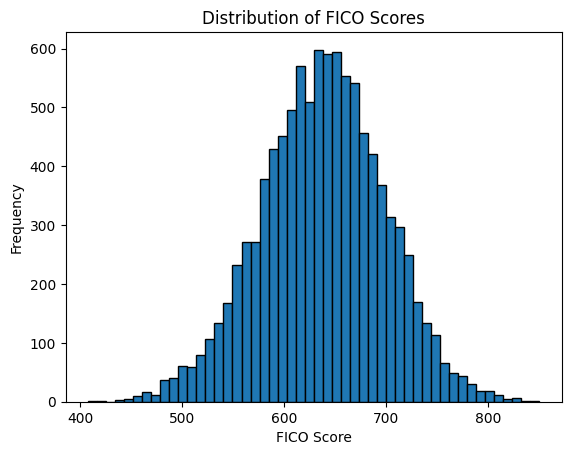

In [12]:
plt.hist(data['fico_score'], bins=50, edgecolor='k')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('Distribution of FICO Scores')
plt.show()

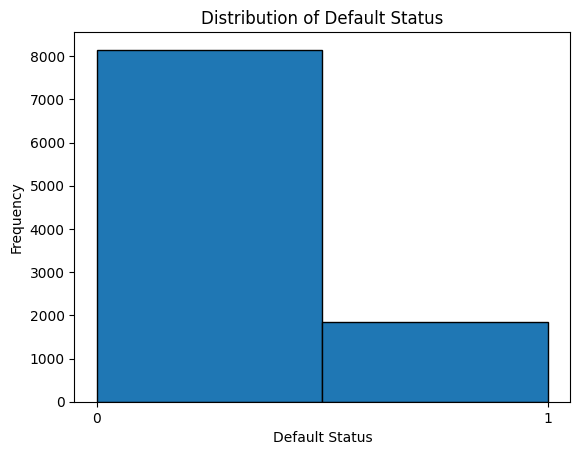

In [14]:
plt.hist(data['default'], bins=2, edgecolor='k')
plt.xlabel('Default Status')
plt.xticks([0, 1])
plt.ylabel('Frequency')
plt.title('Distribution of Default Status')
plt.show()

## Clustering FICO Scores using KMeans

The FICO scores are reshaped into a 2D array since KMeans expects input in this format.

In [15]:
from sklearn.cluster import KMeans
import numpy as np

In [17]:
fico_scores = data['fico_score'].values.reshape(-1, 1)

The KMeans algorithm is applied to segment the FICO scores into 10 clusters. Each FICO score is assigned a cluster label (bucket).

In [18]:
n_buckets = 10  # Number of desired buckets
kmeans = KMeans(n_clusters=n_buckets, random_state=0).fit(fico_scores)
data['Bucket'] = kmeans.labels_

The cluster centers are sorted to define the boundaries of these buckets.

In [19]:
bucket_boundaries = np.sort(kmeans.cluster_centers_.flatten())
print("Bucket boundaries:", bucket_boundaries)

Bucket boundaries: [494.33676976 544.34036939 579.54772727 609.7433414  636.49270286
 661.75868726 686.93811075 713.34705882 742.68318966 786.00588235]


## Optimizing Bucket Boundaries based on Default Likelihood

The FICO scores are sorted, and the default statuses are extracted.

In [20]:
import math
from scipy.optimize import minimize

In [22]:
n_buckets = 10  # Number of desired buckets
fico_scores = data['fico_score'].sort_values().values
default_status = data['default'].values


A function is defined to calculate the log-likelihood of default within each bucket. This function computes the probability of default in each bucket and sums the log-likelihood contributions across all buckets.

In [23]:
def log_likelihood(bucket_boundaries, scores, defaults):
    n_buckets = len(bucket_boundaries) - 1
    log_likelihood = 0
    for i in range(n_buckets):
        bucket_scores = scores[(scores >= bucket_boundaries[i]) & (scores < bucket_boundaries[i + 1])]
        bucket_defaults = defaults[(scores >= bucket_boundaries[i]) & (scores < bucket_boundaries[i + 1])]
        n_i = len(bucket_scores)
        k_i = sum(bucket_defaults)
        p_i = k_i / n_i if n_i > 0 else 0
        if p_i > 0:
            log_likelihood += k_i * math.log(p_i) + (n_i - k_i) * math.log(1 - p_i)
    return log_likelihood

The `log_likelihood` function is key to optimizing the boundaries. Here's a breakdown:
- **Loop through Buckets:** For each bucket, defined by the boundaries `bucket_boundaries[i]` and `bucket_boundaries[i+1]`:
    - **Select Scores and Defaults:** Scores and defaults that fall within the current bucket's range.
    - **Calculate Probabilities:** `n_i` is the number of scores in the bucket, and `k_i` is the number of defaults. `p_i` is the probability of default in the bucket.
    - **Log-Likelihood Calculation:** If `p_i` is greater than 0, the `log_likelihood` for the bucket is computed and added to the total `log_likelihood`.

Initial bucket boundaries are set as evenly spaced values between the minimum and maximum FICO scores. 

In [24]:
initial_boundaries = np.linspace(fico_scores.min(), fico_scores.max(), n_buckets + 1)
result = minimize(lambda b: -log_likelihood(b, fico_scores, default_status), initial_boundaries, method='L-BFGS-B')
optimized_boundaries = result.x

print("Optimized bucket boundaries:", optimized_boundaries)

Optimized bucket boundaries: [408.00000543 452.2        496.4        540.6        584.8
 628.9999991  673.2        717.4        761.6        805.8
 849.99999922]


The `minimize` function from `scipy.optimize` is used to find the bucket boundaries that maximize the log-likelihood (equivalently, minimize the negative log-likelihood).

By optimizing the bucket boundaries to maximize this log-likelihood, we aim to find the boundaries that best separate the scores into buckets with different default probabilities.